# Fast Spectrometry Time Dependence - Stacked Graph

This notebook plots all fast spectrometry signals on a single stacked graph with:
- Each signal having a different color
- The "Whole" signal shown in bold black

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,
        "axes.labelsize": 18,
        "axes.titlesize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.titlesize": 16,
    }
)

In [36]:
shotno = 50742

In [37]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2026-01-03 13:22:08,523 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma start time from http://golem.fjfi.cvut.cz/shots/50742/Diagnostics/PlasmaDetection/Results/t_plasma_start
2026-01-03 13:22:08,559 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma end time from http://golem.fjfi.cvut.cz/shots/50742/Diagnostics/PlasmaDetection/Results/t_plasma_end
2026-01-03 13:22:08,560 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 1.45 - 12.54 ms
2026-01-03 13:22:08,804 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα spectrometry from http://golem.fjfi.cvut.cz/shots/50742/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-03 13:22:08,812 - golem_data_loader.golem_data_loader - INFO - Hα: loaded 19999 rows, columns = ['    0', '0.000']
2026-01-03 13:22:09,309 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hb 486nm spectrometry from http://golem.fjfi.cvut.cz/shots/50742/Diagno

Hα: loaded 19999 rows
Hb 486nm: loaded 19999 rows
He I 588nm: loaded 19999 rows
Whole: loaded 19999 rows
C II 514.5nm: loaded 3999 rows
N II 568.6nm: loaded 3999 rows
O I 777nm: loaded 3999 rows
He I 447.1nm: loaded 3999 rows


In [38]:
transmissions = {
    "Hα": 0.399344466183746,
    "Hb 486nm": 0.3092707494634666,
    "Hg 434nm": 0.32171625016564587,
    "He I 588nm": 0.30580924514216323,
    "C II 514.5nm": 0.4422102032614363,
    "N II 568.6nm": 0.42901271735930263,
    "O I 777nm": 0.28658030783004285,
    "He I 447.1nm": 0.7919005066582551,
    "Cl II 479.5nm": 0.29519876882526447,
    "Whole": 0.1
}

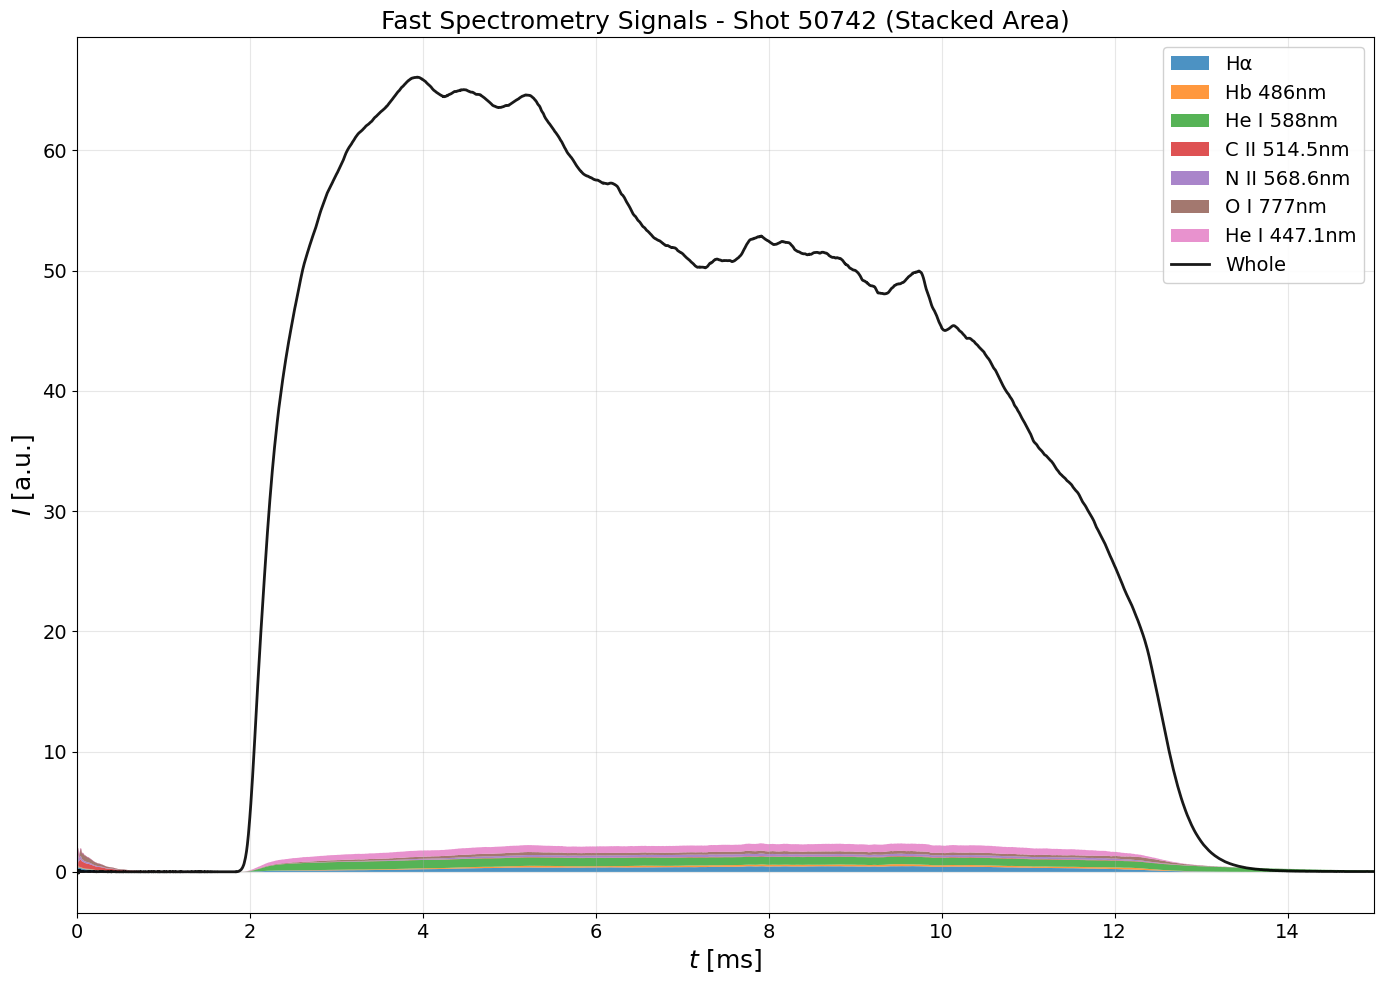

In [39]:
# Create a single figure with stacked area plot
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for all signals
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive']

# Find the signal with highest sampling rate to use as common time grid
max_samples = 0
common_time: np.ndarray | None = None
for label, df in data.items():
    if len(df) > max_samples:
        max_samples = len(df)
        common_time = df.iloc[:, 0].values

# Interpolate all signals to the common time grid
data_interpolated: dict[str, np.ndarray] = {}
if common_time is None:
    raise
for label, df in data.items():
    t_orig: np.ndarray = df.iloc[:, 0].values
    u_orig: np.ndarray = df.iloc[:, 1].values
    
    # Interpolate to common time grid
    u_interp: np.ndarray = np.interp(common_time, t_orig, u_orig)
    data_interpolated[label] = u_interp

# Apply transmission correction to each signal
data_corrected: dict[str, np.ndarray] = {}
for label, u in data_interpolated.items():
        # Divide by transmission to correct for optical losses
        data_corrected[label] = u / transmissions[label]

# Separate "Whole" from other signals
signals_to_stack = [(label, u) for label, u in data_corrected.items() if label != "Whole"]
whole_signal = data_corrected.get("Whole")

# Create stacked area plot with all signals (except Whole)
if signals_to_stack:
    signal_arrays: list[np.ndarray] = []
    signal_labels: list[str] = []
    for label, u in signals_to_stack:
        signal_arrays.append(u)
        signal_labels.append(label)
    
    # Create stacked area plot
    ax.stackplot(common_time * 1e3, *signal_arrays, labels=signal_labels, colors=colors[:len(signal_arrays)], alpha=0.8)

# Plot "Whole" signal as a bold black line on top
if whole_signal is not None:
    ax.plot(common_time * 1e3, whole_signal, label="Whole", color='black', linewidth=2, alpha=0.9, zorder=10)

# Styling
ax.set_xlabel(r"$t$ [ms]")
ax.set_ylabel(r"$I$ [a.u.]")
ax.set_xlim(0, 15)
ax.set_title(f"Fast Spectrometry Signals - Shot {shotno} (Stacked Area)")
ax.grid(True, alpha=0.3)
ax.legend(loc='best', framealpha=0.9)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()